### DATA 620

### Project 4: Word Sense Disambiguation

Keith Folsom 11/26/2017

### Overview 

The Senseval 2 Corpus contains data intended to train word-sense disambiguation classifiers. It contains data for four words: hard, interest, line, and serve. Choose one of these four words, and load the corresponding data.

Using this dataset, build a classifier that predicts the correct sense tag for a given instance.  In this project, the word used for classification will be `interest`.  

#### Import the required packages

In [133]:
import nltk
from nltk.corpus import stopwords
import random
from nltk.corpus import senseval
from nltk.classify import accuracy, NaiveBayesClassifier, MaxentClassifier
from collections import defaultdict
from sklearn.metrics import classification_report
import itertools
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [134]:
nltk.download('senseval')

[nltk_data] Downloading package senseval to
[nltk_data]     C:\Users\kfolsom\AppData\Roaming\nltk_data...
[nltk_data]   Package senseval is already up-to-date!


True

### Understanding the strcture of the Senseval 2 Corpus

Let's see what the target words are in the senseval corpus and how the corpus is structured.

In [135]:
senseval.fileids()

['hard.pos', 'interest.pos', 'line.pos', 'serve.pos']

There are sets of word senses for hard, interest, line, and serve.  Let's look at "interest" specifically, which will be target word used in this project.

In [136]:
senseval.instances('interest.pos')[:1]

[SensevalInstance(word='interest-n', position=18, context=[('yields', 'NNS'), ('on', 'IN'), ('money-market', 'JJ'), ('mutual', 'JJ'), ('funds', 'NNS'), ('continued', 'VBD'), ('to', 'TO'), ('slide', 'VB'), (',', ','), ('amid', 'IN'), ('signs', 'VBZ'), ('that', 'IN'), ('portfolio', 'NN'), ('managers', 'NNS'), ('expect', 'VBP'), ('further', 'JJ'), ('declines', 'NNS'), ('in', 'IN'), ('interest', 'NN'), ('rates', 'NNS'), ('.', '.')], senses=('interest_6',))]

#### How to interpret the data structures in the senseval corpus?

Each entry in the corpus is an instance (noted by SensevalInstance) with four associated attributes:
1. __word__
    * `word` specifies the target word together with its syntactic category; for example, hard-a means that the
word is hard and that its category is adjective;
2. __position__ 
    * `position` gives its position within the sentence (starting with position 0)
3. __context__  
    * `context` represents the sentence as a list of pairs, each consisting of a token and its tag
4. __senses__
    * `senses` is a tuple, each item in the tuple being a sense for the target word; typically, this tuple consists of
only one argument, but there are a few examples in the corpus where there is more than one, representing
the fact that the annotator couldn’t decide which sense to assign to the word; for simplicity, we are going
to ignore any non-first arguments to the attribute senses

In [137]:
interest_instances = senseval.instances('interest.pos')

What are the different categories of the target word `interest` in the corpus?

In [138]:
list(set(i.word[:] for i in interest_instances))

['interest-n']

The single result of `interest-n` shows that the word is interest and with a syntactic category of 'noun.'

What  are the different senses for `interest`:

In [139]:
list(set(i.senses[0] for i in interest_instances))

['interest_4',
 'interest_5',
 'interest_1',
 'interest_2',
 'interest_6',
 'interest_3']

### The 6 uses of the word "interest" in the corpus

1. __interest1:__ a sense of concern with and curiosity about someone or something  
“an interest in music”  

2. __interest2:__ a reason for wanting something done   
“in the interest of safety”  

3. __interest3:__ the power of attracting or holding one’s attention (because it is unusual or exciting etc.)  
“they said nothing of great interest”  

4. __interest4:__ a fixed charge for borrowing money; usually a percentage of the amount borrowed  
“how much interest do you pay on your mortgage?”  

5. __interest5:__ (law) a right or legal share of something; a financial involvement with something  
“they have interests all over the world”  

6. __interest6:__ (usually plural) a social group whose members control some field of activity and who have common aims  
“the iron interests stepped up production”  

What's the frequency distribution of instances by sense?

In [140]:
nltk.FreqDist([i.senses[0] for i in interest_instances])

FreqDist({'interest_1': 361,
          'interest_2': 11,
          'interest_3': 66,
          'interest_4': 178,
          'interest_5': 500,
          'interest_6': 1252})

#### Baseline Model Using the Most Frequent Sense

One approach as a model could be to use the majority sense as a baseline.  In other words, simply using the most frequently occurring sense would result in a certain minimum accuracy for classifier.  

Below, we can see the `interest_6` is the most frequent sense, occurring 1252 times.  Using this sense, we can establish an accuracy of close to 53%.  However, the goal of the exercise is to exceed this using a NaiveBayes classification model. 

In [141]:
interest_sense_fd = nltk.FreqDist([i.senses[0] for i in senseval.instances('interest.pos')])

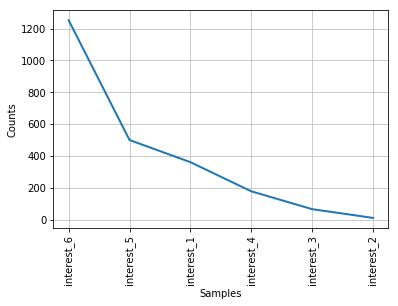

In [142]:
interest_sense_fd.plot(10,cumulative=False)

In [143]:
interest_sense_fd.freq(interest_sense_fd.most_common(1)[0][0])

0.5287162162162162

### Classification Approach

A NaiveBayes classifier will be trained using context features associated with the target word `interest`.  This means the context of the target word will be determined by the collocation of the words and tags around the target word, both to the right and left side of the target word.

For example, if we look at an interest instance example:

__[SensevalInstance(word=u'interest-n', position=18, context=[('yields', 'NNS'), ('on', 'IN'), ('money-market', 'JJ'), ('mutual', 'JJ'), ('funds', 'NNS'), ('continued', 'VBD'), ('to', 'TO'), ('slide', 'VB'), (',', ','), ('amid', 'IN'), ('signs', 'VBZ'), ('that', 'IN'), ('portfolio', 'NN'), ('managers', 'NNS'), ('expect', 'VBP'), ('further', 'JJ'), ('declines', 'NNS'), ('in', 'IN'), ('interest', 'NN'), ('rates', 'NNS'), ('.', '.')], senses=('interest_6',))]__

The word-tag pairs to the immediate right and left of the word `interest` (identified in position 18) are:
    * ('in', 'IN')
    * ('rates', 'NNS')
   
The word and the POS tag are provided.  In this case, the distance is 1 -- 1 pair before and 1 pair after the target word in the sentence.

A distance of 2 would look like:
    * ('declines', 'NNS') ('in', 'IN')
    * ('rates', 'NNS'), ('.', '.')

### Feature Extractors - Evolution and Selection

Test various feature extractors using the word context approach outlined above.

In [144]:
# create training and test data sets
size = int( len( interest_instances) * 0.1) 
train_set, test_set = interest_instances[size:], interest_instances[:size]

In [145]:
# test using the word-tag pairs a distance of 1 from the target word's position
def feature_extractor1(instance):
    ind = instance.position
    return {
               'pre-1'  : instance.context[ind-1],
               'post-1' : instance.context[ind+1]
           }

In [146]:
def featureset(data, extractor):
   return [(extractor(inst), inst.senses[0]) for inst in data]

In [147]:
# train the classifier
classifier = nltk.NaiveBayesClassifier.train(featureset(train_set, feature_extractor1))

# check the accuracy against the test test
acc = accuracy(classifier, (featureset(test_set, feature_extractor1)) )

print('Accuracy: %6.4f' % acc)

Accuracy: 0.8602


In [148]:
def feature_extractor2(instance):
    ind = instance.position
    return {
               'pre-2'  : instance.context[ind-2],
               'pre-1'  : instance.context[ind-1],
               'post-1' : instance.context[ind+1]
           }

In [149]:
# train the classifier
classifier = nltk.NaiveBayesClassifier.train(featureset(train_set, feature_extractor2))

# check the accuracy against the test test
acc = accuracy(classifier, (featureset(test_set, feature_extractor2)) )

print('Accuracy: %6.4f' % acc)

Accuracy: 0.8729


In [150]:
def feature_extractor3(instance):
    ind = instance.position
    return {
               'pre-3'  : instance.context[ind-3],
               'pre-2'  : instance.context[ind-2],
               'pre-1'  : instance.context[ind-1],
               'post-1' : instance.context[ind+1]
           }

In [151]:
classifier = nltk.NaiveBayesClassifier.train(featureset(train_set, feature_extractor3))

# check the accuracy against the test test
acc = accuracy(classifier, (featureset(test_set, feature_extractor3)) )

print('Accuracy: %6.4f' % acc)

Accuracy: 0.8898


With these quick tests of accuracy we can see that providing more context through adding the number of word-tag pairs to the left and right of the target word increases the accuracy.

In [152]:
def feature_extractor_dist(instance, dist=6):
    
    features = {}
    ind = instance.position
    con = instance.context
    for i in range(max(0, ind-dist), ind):
        j = ind-i
        features['previous-%s' % (j)] = con[i]
    
    features['post+1'] = con[ind+1]
        
    return features

#### Create an extractor function that accepts as a parameter the distance to the right and left of the target word for the number of word-tag pairs to include.

The `feature_extractor_dist2` function below is the feature extractor used in the more detailed classification process below which will focus on optimizing the distance to find the best classsifier

In [153]:
def feature_extractor_dist2(instance, dist=6):
    
    features = {}
    ind = instance.position
    con = instance.context
    for i in range(max(0, ind-dist), ind):
        j = ind-i
        features['previous-%s' % (j)] = con[i]
     
    for i in range(ind+1, min(ind+dist+1, len(con))):
        j = i-ind
        features['post-%s' % (j)] = con[i]
            
    return features  

### Word Sense Disambiugation Classification

In [154]:
def cr2df(cr, classifier_name=None, distance=None):
    # Parse rows
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)
    
    # Store in dictionary
    measures = tmp[0]

    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    
    ret = pd.DataFrame.from_dict(D_class_data, orient="index")

    # add the classifier name and distance to the dataframe if provided
    if classifier_name is not None: ret['classifier'] = classifier_name 
    if distance is not None: ret['distance'] = distance 
    
    return ret  

In [155]:
#https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report

def plot_classification_report(cr, title='Classification Report', cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        plotMat.append(v)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')



In [163]:
### Main Function ##
### Based on and extended from the NLTK Example ###

_inst_cache = {}

def wsd_classifier(trainer, word, feature_extractor, dist, displayOutput = True, show_errors = 5):
    
    # Get the instances.
    if displayOutput: print('Reading data...')
    global _inst_cache
    if word not in _inst_cache:
        _inst_cache[word] = [(i, i.senses[0]) for i in senseval.instances(word)]
    instances = _inst_cache[word][:]
    n = len(instances)
    senses = list(set(l for (i, l) in instances))
    if displayOutput: print('  Senses: ' + ' '.join(senses))
    
    sense_fd = nltk.FreqDist([i.senses[0] for i in senseval.instances(word)])
    
    if displayOutput: 
        sense_fd.plot(10,cumulative=False)
        print("Most Common Instance Sense", sense_fd.most_common(1))
        print('\nBaseline Classifier...')
        print("   Baseline Frequency: ", sense_fd.freq(sense_fd.most_common(1)[0][0]))

    # Randomly split the names into a test & train set.
    if displayOutput:  print('\nSplitting into test & train...')
    random.seed(123456)
    random.shuffle(instances)
    train = instances[:int(.9*n)]
    test = instances[int(.1*n):n]

    # Train up a classifier.
    if displayOutput: print('\nTraining classifier...')
    classifier = trainer([(feature_extractor(i, dist), l) for (i, l) in train])
    acc = accuracy(classifier, [(feature_extractor(i, dist), l) for (i, l) in train])
    if displayOutput: print('Train Accuracy: %6.4f' % acc)

    # Run the classifier on the test data.
    if displayOutput: print('\nTesting classifier...')
    acc = accuracy(classifier, [(feature_extractor(i, dist), l) for (i, l) in test])
    if displayOutput: print('Test Accuracy: %6.4f' % acc)

    # Errors 
    errors = []
    for (i, label) in test:
       guess = classifier.classify(feature_extractor(i, dist))
        
       if guess != label:
                con =  i.context
                position = i.position
                #item_number = str(test.index((i, label)))
                word_list = []
                #for (word, tag) in con:
                #    word_list.append(word)
                #hard_highlighted = word_list[position].upper()
                #word_list_highlighted = word_list[0:position] + [hard_highlighted] + word_list[position+1:]
                #sentence = ' '.join(word_list_highlighted)
                errors.append([con, guess,label]) #item_number,
                
    
    ## Confusion Matrix 
    if displayOutput: 
        print("\nConfusion Matrix (Test)")
        print("................................\n")
    gold = [label for (i, label) in test]
    predicted = [classifier.classify(feature_extractor(i, dist)) for (i,label) in test]
    cm = nltk.ConfusionMatrix(gold,predicted)
    if displayOutput: print(cm)
    
    ## Classification Report 
    if displayOutput: 
        print("\nClassification Report (Test)")
        print("................................\n")
        
    # create table with precision, recall, f1-score, and support
    train_report=classification_report(gold, predicted, digits=4)
    if displayOutput: 
        print(train_report)
        plot_classification_report(train_report)
        #most informative features
        classifier.show_most_informative_features(10)

    ## errors
    if displayOutput: 
        
        print("\nErrors")
        print("................................\n")
        for (sentence, guess, label) in sorted(errors[:show_errors]):
            print('CORRECT=%s GUESS=%s SENTENCE=%s'%( label, guess, sentence))
    
    
    # Return the classifier
    return classifier, train_report, gold, predicted, test

#### Using the collocation approach, determine the optimal distance to use in the feature extractor based on the average f1-score from the resulting classification reports.

Train the classifier using distances ranging from 1 - 10 and store the resulting classification reports from each model.

In [157]:
all_reports = pd.DataFrame()

for dist in range(1, 11):
  classifier, cr, gold, predicted, test = wsd_classifier(NaiveBayesClassifier.train, 'interest.pos', \
                                                         feature_extractor_dist2, dist= dist, \
                                                         displayOutput=False)

  # convert the classification report to a dataframe
  report = cr2df(cr, 'feature_extractor_dist2-'+str(dist), dist)
    
  # append the individual reports to a single dataframe for reporting
  all_reports = all_reports.append(report, ignore_index=False)

C:\Users\kfolsom\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Sort the combined classifcation resports on the avg/total f1-score to determined the optimized distance to use in the classifier.

In [158]:
all_reports.loc[["avg / total"]].sort_values(by='f1-score', ascending=0)

,precision,recall,f1-score,support,classifier,distance
avg / total,0.9808,0.9803,0.9804,2132.0,feature_extractor_dist2-10,10
avg / total,0.9798,0.9794,0.9795,2132.0,feature_extractor_dist2-8,8
avg / total,0.9798,0.9794,0.9795,2132.0,feature_extractor_dist2-9,9
avg / total,0.9792,0.9789,0.9790,2132.0,feature_extractor_dist2-7,7
avg / total,0.9764,0.9761,0.9762,2132.0,feature_extractor_dist2-6,6
avg / total,0.9717,0.9709,0.9709,2132.0,feature_extractor_dist2-5,5
avg / total,0.9675,0.9667,0.9666,2132.0,feature_extractor_dist2-4,4
avg / total,0.9648,0.9639,0.9636,2132.0,feature_extractor_dist2-3,3
avg / total,0.9439,0.9418,0.9402,2132.0,feature_extractor_dist2-2,2
avg / total,0.9025,0.9057,0.9029,2132.0,feature_extractor_dist2-1,1


### Using a distance of 10 yields the best f1-score 

Let's run the classifier and show the output.

Reading data...
  Senses: interest_4 interest_5 interest_1 interest_2 interest_6 interest_3


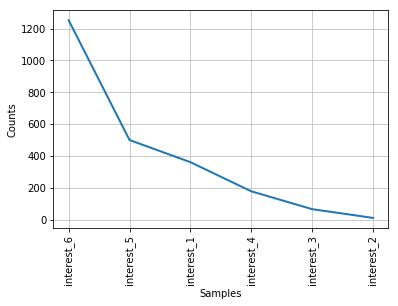

Most Common Instance Sense [('interest_6', 1252)]

Baseline Classifier...
   Baseline Frequency:  0.5287162162162162

Splitting into test & train...

Training classifier...
Train Accuracy: 0.9991

Testing classifier...
Test Accuracy: 0.9803

Confusion Matrix (Test)
................................

           |    i    i    i    i    i    i |
           |    n    n    n    n    n    n |
           |    t    t    t    t    t    t |
           |    e    e    e    e    e    e |
           |    r    r    r    r    r    r |
           |    e    e    e    e    e    e |
           |    s    s    s    s    s    s |
           |    t    t    t    t    t    t |
           |    _    _    _    _    _    _ |
           |    1    2    3    4    5    6 |
-----------+-------------------------------+
interest_1 | <317>   .    .    5    4    . |
interest_2 |    1  <10>   .    .    .    . |
interest_3 |    .    .  <55>   2    .    . |
interest_4 |    3    .    . <162>   .    1 |
interest_5 |    5    .   

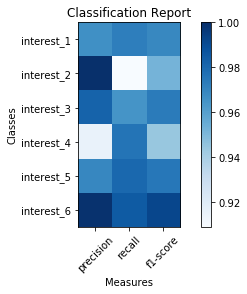

In [159]:
classifier, cr, gold, predicted, test = wsd_classifier(NaiveBayesClassifier.train, 'interest.pos', \
                                                       feature_extractor_dist2, dist = 10)

### Let's try the WSD classifier on the remaining three words - hard, serve, and line.

Reading data...
  Senses: HARD2 HARD3 HARD1


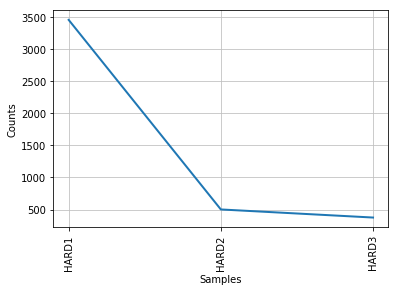

Most Common Instance Sense [('HARD1', 3455)]

Baseline Classifier...
   Baseline Frequency:  0.797369028386799

Splitting into test & train...

Training classifier...
Train Accuracy: 0.9841

Testing classifier...
Test Accuracy: 0.9690

Confusion Matrix (Test)
................................

      |    H    H    H |
      |    A    A    A |
      |    R    R    R |
      |    D    D    D |
      |    1    2    3 |
------+----------------+
HARD1 |<3021>  64   28 |
HARD2 |   16 <436>   2 |
HARD3 |    6    5 <322>|
------+----------------+
(row = reference; col = test)


Classification Report (Test)
................................

             precision    recall  f1-score   support

      HARD1     0.9928    0.9704    0.9815      3113
      HARD2     0.8634    0.9604    0.9093       454
      HARD3     0.9148    0.9670    0.9401       333

avg / total     0.9710    0.9690    0.9695      3900

Most Informative Features
                  post-1 = ('to', 'TO')    HARD1 : HARD2  =    230.

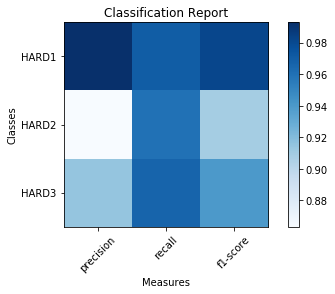

In [160]:

classifier, cr, gold, predicted, test  = wsd_classifier(NaiveBayesClassifier.train, 'hard.pos', \
                                                       feature_extractor_dist2, dist = 10)

Reading data...
  Senses: SERVE12 SERVE10 SERVE6 SERVE2


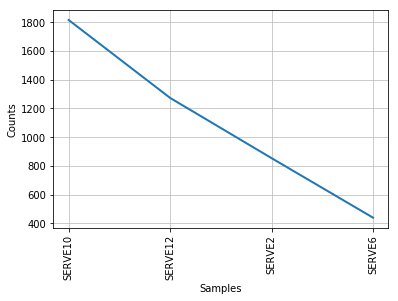

Most Common Instance Sense [('SERVE10', 1814)]

Baseline Classifier...
   Baseline Frequency:  0.4143444495203289

Splitting into test & train...

Training classifier...
Train Accuracy: 0.9992

Testing classifier...
Test Accuracy: 0.9845

Confusion Matrix (Test)
................................

        |    S    S           |
        |    E    E    S    S |
        |    R    R    E    E |
        |    V    V    R    R |
        |    E    E    V    V |
        |    1    1    E    E |
        |    0    2    2    6 |
--------+---------------------+
SERVE10 |<1621>   8    9    8 |
SERVE12 |    2<1129>  11    2 |
 SERVE2 |    2    6 <771>   1 |
 SERVE6 |    2    4    6 <359>|
--------+---------------------+
(row = reference; col = test)


Classification Report (Test)
................................

             precision    recall  f1-score   support

    SERVE10     0.9963    0.9848    0.9905      1646
    SERVE12     0.9843    0.9869    0.9856      1144
     SERVE2     0.9674    0.9885

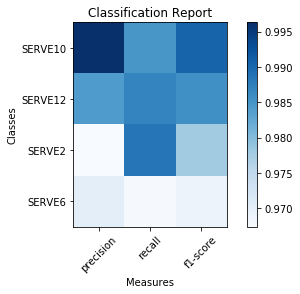

In [161]:
classifier, cr, gold, predicted, test  = wsd_classifier(NaiveBayesClassifier.train, 'serve.pos', \
                                                        feature_extractor_dist2, dist = 10)

Reading data...
  Senses: cord text division formation product phone


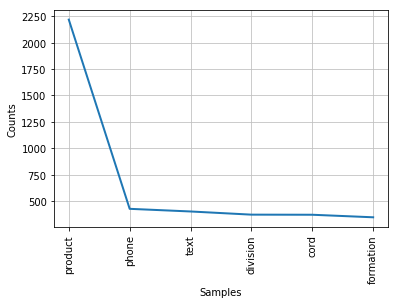

Most Common Instance Sense [('product', 2217)]

Baseline Classifier...
   Baseline Frequency:  0.5347322720694645

Splitting into test & train...

Training classifier...
Train Accuracy: 0.9992

Testing classifier...
Test Accuracy: 0.9759

Confusion Matrix (Test)
................................

          |              f                |
          |         d    o                |
          |         i    r         p      |
          |         v    m         r      |
          |         i    a    p    o      |
          |    c    s    t    h    d    t |
          |    o    i    i    o    u    e |
          |    r    o    o    n    c    x |
          |    d    n    n    e    t    t |
----------+-------------------------------+
     cord | <327>   1    2    3    3    2 |
 division |    . <325>   2    3    .    2 |
formation |    5    1 <303>   1    1    4 |
    phone |    3    .    3 <381>   1    3 |
  product |    6    5    2    6<1959>  16 |
     text |    6    .    2    4    3 <347>|

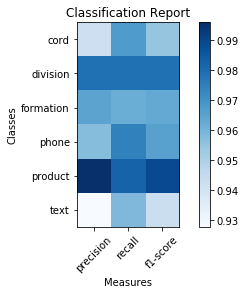

In [162]:
classifier, cr, gold, predicted, test  = wsd_classifier(NaiveBayesClassifier.train, 'line.pos', \
                                                        feature_extractor_dist2, dist = 10)